In [1]:
%pip install statsmodels
%pip install python-dotenv

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   -------------------------- ------------- 6.6/9.8 MB 44.6 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 38.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import PIconnect as PI
from datetime import datetime
from PIconnect.PIConsts import SummaryType
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.model_selection import train_test_split
from typing import Union
import os
from dotenv import load_dotenv

OSIsoft(r) AF SDK Version: 3.0.2.5


In [ ]:
# Cargar variables desde .env
load_dotenv()

# Usar las variables
conectar = os.getenv("PI_SERVER")
servidor = PIServer(server=conectar)
PIConfig.DEFAULT_TIMEZONE = os.getenv("PI_TIMEZONE")

print(f"Se ha conectado al servidor {servidor}")

 Se ha conectado al servidor PIServer(\\CLMAPPIDATAPRD) 


In [4]:
# Esta funcion se encargara de buscar en la libreria los datos, los nombres de los tags, la descripcion y la unidad de medidad y la concatenara en el nombre de columna de forma automatica.
def taginfo(tags, startTime, endTime):

    dataset = servidor.search(tags)
    taginfo = {point.name: {"desc": f"{point.description} [{point.units_of_measurement}]",
                            "uom": f"[{point.units_of_measurement}]"} for point in dataset}

    # Extracción de desc y uom como listas separadas
    desc = [taginfo[tag]["desc"] if tag in taginfo else "Favor Revisar TAG" for tag in tags]
    uom = [taginfo[tag]["uom"] if tag in taginfo else "Unidad no disponible" for tag in tags]

    # Cálculo de días de análisis
    dias_analisis = abs((datetime.strptime(startTime, "%d-%m-%Y %H:%M") - datetime.strptime(endTime, "%d-%m-%Y %H:%M")).days)

    # Imprimir información
    for i, tag in enumerate(tags):
        print(f"{tag} = {desc[i]}")

    print(f"Se consideran {dias_analisis} días para este análisis")

    return dataset, desc, uom, dias_analisis


In [5]:
# Aca podemos poner uno o varios tags para un mismo tiempo de muestreo
tags = ['753LAB142.QC', #carbonato
        '753LAB139.QC', # att
        '753LAB143.QC', #sulfidez
        '753LAB343.QC', #Sedimentables
        '753LAB342.QC',
        '753PDIC0240.MV', #difrenecial presion lv1
        '753FICQ0336.MV', #Caudal entrada filtro 2
        '753FICQ0236.MV', #Caudal entrada filtro 1
        '753PICZ0246.MV', #Presion filtro 1 XD
        '753FICQ0336_EfficiencyFilt.MV',
        '753FICQ0236_EfficiencyFilt.MV',
        '753PIZ0245.MV', #presion filtro 1
        '753PIZ0345.MV', #presion filtro 2
        '753LIT0269.MV', #Nivel estanque rgl
        '753LIT0226.MV', #Nivel estanque rgl2
        '753SEQ0265.Run', #Filtración f1
        '753SEQ0266.Run', #Lavado f1
        '753SEQ0365.Run', #Filtración f2
        '753SEQ0366.Run', #Lavado f2
]
startTime = "01-10-2024 23:00"
endTime = "21-03-2025 12:00"
interval = '1m'
dataset, desc, uom, dias_analisis = taginfo(tags, startTime, endTime) # Aca llamamos a la primera funcion.

753LAB142.QC = Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]
753LAB139.QC = Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]
753LAB143.QC = Análisis Sulfidez (%) LV Crudo. Estanque LV Crudo [%]
753LAB343.QC = Sólidos sedimentables LV Tk LV crudo [mg/L]
753LAB342.QC = SST LV TK LV crudo [mg/L]
753PDIC0240.MV = Presion diferencial filtro licor verde 1 [bar]
753FICQ0336.MV = Flujo alimentacion licor verde crudo filtro licor verde 2 [m³/h]
753FICQ0236.MV = Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h]
753PICZ0246.MV = Presion linea DNCG filtro licor verde 1 (SRS) [bar]
753FICQ0336_EfficiencyFilt.MV = Eficiencia filtro licor verde 2 [m³/h]
753FICQ0236_EfficiencyFilt.MV = Eficiencia filtro licor verde 1 [m³/h]
753PIZ0245.MV = Presion tope filtro de licor verde 1 [barg]
753PIZ0345.MV = Presion tope filtro de licor verde 2 [barg]
753LIT0269.MV = Nivel estanque de licor verde crudo - Medidor tipo radar [%]
753LIT0226.MV = Nivel estanque de lic

In [6]:
dataset

[PIPoint(753LAB142.QC, Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo; Current Value: 115.12000274658203 g/L NaOH),
 PIPoint(753LAB139.QC, Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo; Current Value: 160.47999572753906 g/L NaOH),
 PIPoint(753LAB143.QC, Análisis Sulfidez (%) LV Crudo. Estanque LV Crudo; Current Value: 25.420000076293945 %),
 PIPoint(753LAB343.QC, Sólidos sedimentables LV Tk LV crudo; Current Value: 58.0 mg/L),
 PIPoint(753LAB342.QC, SST LV TK LV crudo; Current Value: 2960.0 mg/L),
 PIPoint(753PDIC0240.MV, Presion diferencial filtro licor verde 1; Current Value: 0.0207521915435791 bar),
 PIPoint(753FICQ0336.MV, Flujo alimentacion licor verde crudo filtro licor verde 2; Current Value: 559.3911743164062 m³/h),
 PIPoint(753FICQ0236.MV, Flujo alimentacion licor verde crudo filtro licor verde 1; Current Value: 0.37079423666000366 m³/h),
 PIPoint(753PICZ0246.MV, Presion linea DNCG filtro licor verde 1 (SRS); Current Value: 2.0504462718963623 bar),
 PIPoint(753FIC

In [7]:
#Importacion de datos y analsiis de composicion

#Generacion de Dataframe
df = pd.concat([tag.interpolated_values(startTime, endTime, interval) for tag in dataset], axis=1)
df = df.apply(pd.to_numeric, errors='coerce')

# Seteo de Nombres de Columnas
colnames = {columna_actual: desc for columna_actual, desc in zip(df.columns, desc)}
df.rename(columns=colnames, inplace=True)
df.index = pd.to_datetime(df.index)          # Asegura que el índice sea datetime
df = df.rename_axis("timestamp").reset_index()  # Mueve el índice al DataFrame con nombre "timestamp"
df.set_index("timestamp", inplace=True)      # Lo vuelve a poner como índice



print("Analisis de Composicion de datos")
print("Todos los datos han sido transformados a valores numericos.")
df

Analisis de Composicion de datos
Todos los datos han sido transformados a valores numericos.


,Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis Sulfidez (%) LV Crudo. Estanque LV Crudo [%],Sólidos sedimentables LV Tk LV crudo [mg/L],SST LV TK LV crudo [mg/L],Presion diferencial filtro licor verde 1 [bar],Flujo alimentacion licor verde crudo filtro licor verde 2 [m³/h],Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h],Presion linea DNCG filtro licor verde 1 (SRS) [bar],Eficiencia filtro licor verde 2 [m³/h],Eficiencia filtro licor verde 1 [m³/h],Presion tope filtro de licor verde 1 [barg],Presion tope filtro de licor verde 2 [barg],Nivel estanque de licor verde crudo - Medidor tipo radar [%],Nivel estanque de licor verde crudo - Medidor tipo presión [%],Secuencia de filtrado filtro LV1 [],Secuencia de lavado tela Filtro LV1 [],Secuencia de filtrado filtro LV2 [],Secuencia de lavado tela Filtro LV2 []
timestamp,,,,,,,,,,,,,,,,,,,
2024-10-01 23:00:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.676338,730.650269,763.608398,2.476112,506.907104,290.245392,2.518227,2.195956,36.0,30.0,-1.0,0.0,0.0,-1.0
2024-10-01 23:01:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.299652,699.829346,851.942139,2.525761,506.907104,290.245392,2.562335,2.198271,36.0,30.0,-1.0,0.0,0.0,-1.0
2024-10-01 23:02:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.478163,758.210388,720.229919,2.338506,506.907104,290.245392,2.368340,2.193759,36.0,30.0,-1.0,0.0,0.0,-1.0
2024-10-01 23:03:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.440353,733.524353,723.498535,2.203888,506.907104,290.245392,2.233066,2.195963,36.0,29.0,-1.0,0.0,0.0,-1.0
2024-10-01 23:04:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.474917,679.823730,683.636902,2.307549,506.907104,290.245392,2.349122,2.199374,36.0,29.0,-1.0,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21 11:56:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.647074,0.565284,666.962708,2.664509,300.668884,397.912964,2.712239,1.853755,34.0,27.0,-1.0,0.0,-1.0,0.0
2025-03-21 11:57:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.629553,0.631724,657.800476,2.671305,300.668884,397.912964,2.709567,1.678798,34.0,27.0,-1.0,0.0,-1.0,0.0
2025-03-21 11:58:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.633434,0.631724,637.889404,2.609671,300.668884,397.912964,2.650021,1.663910,34.0,27.0,-1.0,0.0,-1.0,0.0


C:\Users\ext.anibal.polanco\AppData\Local\Temp\ipykernel_8504\820824164.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00909090909090909' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Clogging_Risk_Score')] = min(max(score / 110, 0), 1000)


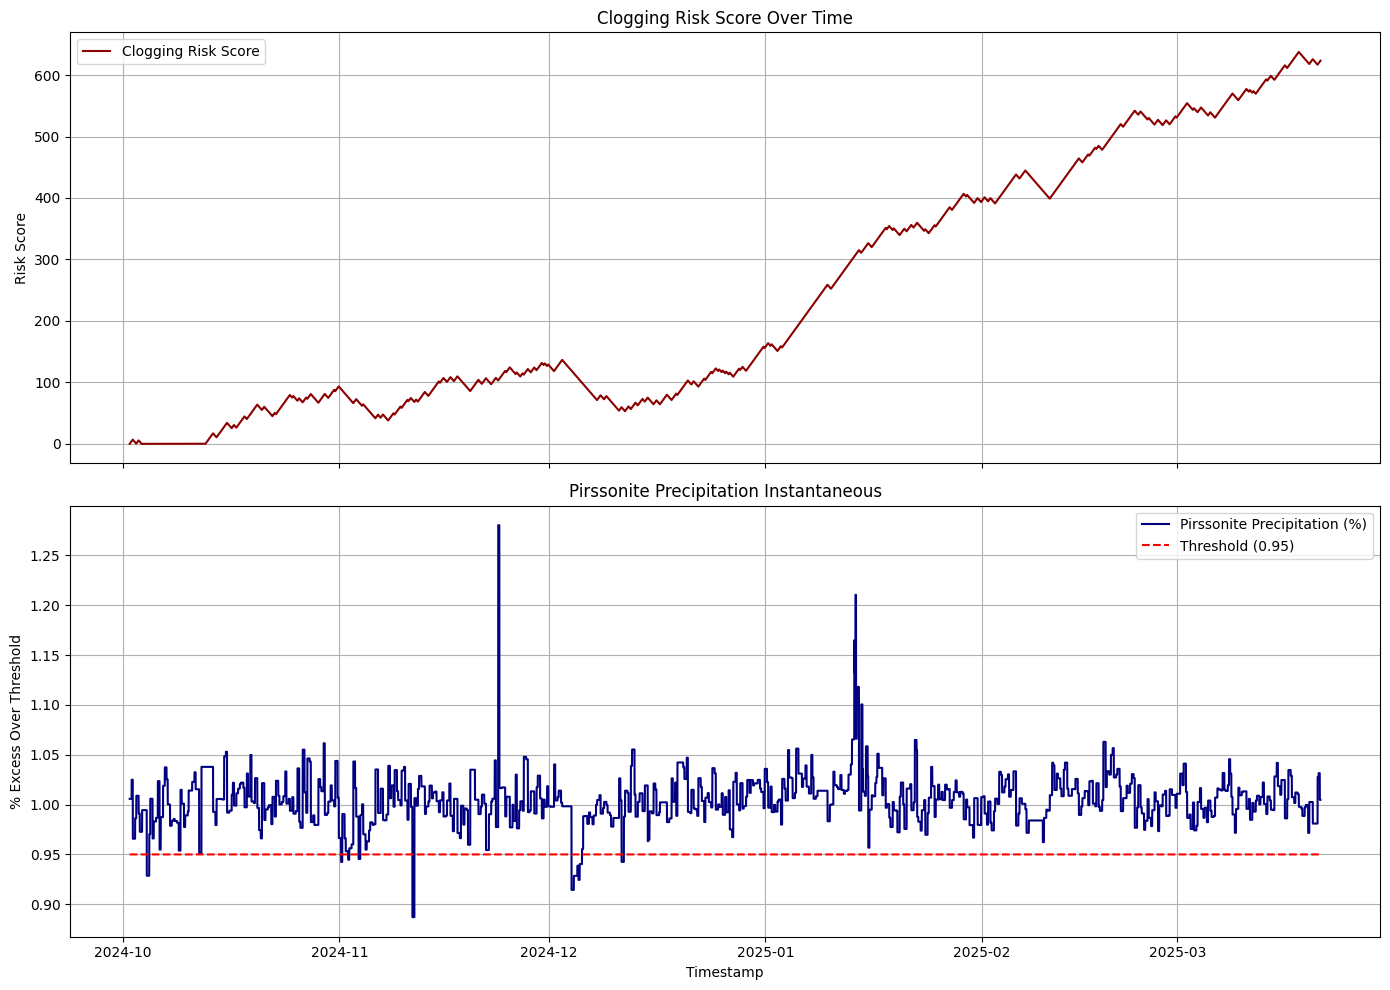

In [8]:
df['Solubilidad Pirsonita 95°C'] = (212.79-1.397*(df['Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]']*0.775) + 0.00598*(df['Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]']*0.775)**2)/0.775
df['ATT límite Teórico 2da ecc'] = .006*(df['Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]']**2) - 1.5084*(df['Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]']) + 260.14

import numpy as np

# Step 1: Calculate the ratio and flag potential clogging
df['ATT_Solubilidad_Ratio'] = df['Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH]'] / df['ATT límite Teórico 2da ecc']
df['Clogging_Flag'] = (df['ATT_Solubilidad_Ratio'] > 1).astype(int)
df['pirssonite_precipitation_instanteous'] = np.maximum((df['ATT_Solubilidad_Ratio'] - 0.95) * 100, 0)

# Step 2: Initialize scoring column
df['Clogging_Risk_Score'] = 0
score = 0
streak = 0  # Count of consecutive clogging rows
neg_streak = 0  # Count of consecutive non-clogging rows
# Step 3: Iterate using .iloc to avoid KeyError with datetime index
for i in range(len(df)):
    flag = df['Clogging_Flag'].iloc[i]
    
    if flag == 1:
        neg_streak = 0
        streak += 1
        if streak > 0 and streak % 10 == 0:
            score += 3
        else:
            score += 1
    else:
        streak = 0  # reset streak
        neg_streak += 1

        score -= 1



    df.iloc[i, df.columns.get_loc('Clogging_Risk_Score')] = min(max(score / 110, 0), 1000)

#################################


import matplotlib.pyplot as plt

# Crear una máscara para donde se supera el umbral
threshold_exceeded = df['pirssonite_precipitation_instanteous'] > 0

# Crear la figura
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: Clima de taponamiento
ax[0].plot(df.index, df['Clogging_Risk_Score'], label='Clogging Risk Score', color='darkred')
ax[0].set_title('Clogging Risk Score Over Time')
ax[0].set_ylabel('Risk Score')
ax[0].grid(True)
ax[0].legend()

# Plot 2: Eventos de precipitación de pirssonita
ax[1].plot(df.index, df['ATT_Solubilidad_Ratio'], label='Pirssonite Precipitation (%)', color='navy', linestyle='-')
ax[1].plot(df.index, [0.95] * len(df), label='Threshold (0.95)', color='red', linestyle='--')



ax[1].set_title('Pirssonite Precipitation Instantaneous')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('% Excess Over Threshold')
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()
#################################
df = df.drop(columns=['ATT_Solubilidad_Ratio', 'Clogging_Flag'], axis=1)
stats = df['Clogging_Risk_Score'].describe()


In [9]:
index_name = df.index.name

df_lv1 = df[df["Secuencia de filtrado filtro LV1 []"] == -1].copy()
df_lv2 = df[df["Secuencia de filtrado filtro LV2 []"] == -1].copy()
df_lv1.index.name = index_name
df_lv2.index.name = index_name

print(df_lv1.index)
df_lv1

DatetimeIndex(['2024-10-01 23:00:00-03:00', '2024-10-01 23:01:00-03:00',
               '2024-10-01 23:02:00-03:00', '2024-10-01 23:03:00-03:00',
               '2024-10-01 23:04:00-03:00', '2024-10-01 23:05:00-03:00',
               '2024-10-01 23:06:00-03:00', '2024-10-01 23:07:00-03:00',
               '2024-10-01 23:08:00-03:00', '2024-10-01 23:09:00-03:00',
               ...
               '2025-03-21 11:51:00-03:00', '2025-03-21 11:52:00-03:00',
               '2025-03-21 11:53:00-03:00', '2025-03-21 11:54:00-03:00',
               '2025-03-21 11:55:00-03:00', '2025-03-21 11:56:00-03:00',
               '2025-03-21 11:57:00-03:00', '2025-03-21 11:58:00-03:00',
               '2025-03-21 11:59:00-03:00', '2025-03-21 12:00:00-03:00'],
              dtype='datetime64[ns, Etc/GMT+3]', name='timestamp', length=140304, freq=None)


,Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis Sulfidez (%) LV Crudo. Estanque LV Crudo [%],Sólidos sedimentables LV Tk LV crudo [mg/L],SST LV TK LV crudo [mg/L],Presion diferencial filtro licor verde 1 [bar],Flujo alimentacion licor verde crudo filtro licor verde 2 [m³/h],Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h],Presion linea DNCG filtro licor verde 1 (SRS) [bar],Eficiencia filtro licor verde 2 [m³/h],...,Nivel estanque de licor verde crudo - Medidor tipo radar [%],Nivel estanque de licor verde crudo - Medidor tipo presión [%],Secuencia de filtrado filtro LV1 [],Secuencia de lavado tela Filtro LV1 [],Secuencia de filtrado filtro LV2 [],Secuencia de lavado tela Filtro LV2 [],Solubilidad Pirsonita 95°C,ATT límite Teórico 2da ecc,pirssonite_precipitation_instanteous,Clogging_Risk_Score
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 23:00:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.676338,730.650269,763.608398,2.476112,506.907104,...,36.0,30.0,-1.0,0.0,0.0,-1.0,175.137978,165.99856,5.579190,0.009091
2024-10-01 23:01:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.299652,699.829346,851.942139,2.525761,506.907104,...,36.0,30.0,-1.0,0.0,0.0,-1.0,175.137978,165.99856,5.579190,0.018182
2024-10-01 23:02:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.478163,758.210388,720.229919,2.338506,506.907104,...,36.0,30.0,-1.0,0.0,0.0,-1.0,175.137978,165.99856,5.579190,0.027273
2024-10-01 23:03:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.440353,733.524353,723.498535,2.203888,506.907104,...,36.0,29.0,-1.0,0.0,0.0,-1.0,175.137978,165.99856,5.579190,0.036364
2024-10-01 23:04:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,0.474917,679.823730,683.636902,2.307549,506.907104,...,36.0,29.0,-1.0,0.0,0.0,-1.0,175.137978,165.99856,5.579190,0.045455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21 11:56:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.647074,0.565284,666.962708,2.664509,300.668884,...,34.0,27.0,-1.0,0.0,-1.0,0.0,174.374565,165.73072,5.476245,623.372727
2025-03-21 11:57:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.629553,0.631724,657.800476,2.671305,300.668884,...,34.0,27.0,-1.0,0.0,-1.0,0.0,174.374565,165.73072,5.476245,623.381818
2025-03-21 11:58:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,1.633434,0.631724,637.889404,2.609671,300.668884,...,34.0,27.0,-1.0,0.0,-1.0,0.0,174.374565,165.73072,5.476245,623.390909


## Cálculo de estadísticos por ejecución

In [10]:
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid

def create_df_youmake(df, flow_col, pressure_col='Presion linea DNCG filtro licor verde 1 (SRS) [bar]'):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    time_diffs = df.index.to_series().diff().dt.total_seconds().div(60)
    execution_labels = (time_diffs > 20).cumsum()
    df['Execution_Label'] = execution_labels

    stat_cols = [
        'Duration_min', 'Flow_AUC', 'Performance', 'Mean_Flow',
        'Min_Flow', 'Max_Flow', 'Std_Flow',
        'Maximum_Operating_Pressure', 'Relative_Time_To_Max_Pressure',
        'Differential_Pressure_Growth_Rate'
    ]
    for col in stat_cols:
        df[col] = np.nan

    for label, segment in df.groupby('Execution_Label'):
        if len(segment) < 5:
            continue

        x = (segment.index - segment.index[0]).total_seconds() / 60
        y_flow = segment[flow_col].values
        y_presion = segment[pressure_col].values

        # Nuevo: diferencial de presión
        diff_col = 'Presion diferencial filtro licor verde 1 [bar]'
        if diff_col not in segment.columns:
            continue  # salta si no existe

        y_diff = segment[diff_col].values

        duration = x[-1]
        auc = trapezoid(y_flow, x)
        performance = auc / duration if duration > 0 else np.nan

        # Cálculo presión operativa máxima
        tail_start = int(len(y_presion) * 0.7)
        tail_pressure = y_presion[tail_start:]
        if len(tail_pressure) >= 5:
            threshold = np.percentile(tail_pressure, 90)
            stable_high_values = tail_pressure[tail_pressure >= threshold]
            max_operating_pressure = np.median(stable_high_values)
            try:
                max_pressure_value = np.max(tail_pressure)
                max_pressure_idx = np.where(y_presion == max_pressure_value)[0][0]
                relative_time_to_max_pressure = max_pressure_idx / len(y_presion)
            except:
                relative_time_to_max_pressure = np.nan
            try:
                # Usamos los mismos índices que tail_pressure
                tail_diff = y_diff[tail_start:]
                if len(tail_diff) >= 2:
                    time_tail = x[tail_start:]  # tiempo correspondiente al tail
                    pressure_growth_rate = (tail_diff[-1] - tail_diff[0]) / (time_tail[-1] - time_tail[0]) if (time_tail[-1] - time_tail[0]) > 0 else np.nan
                else:
                    pressure_growth_rate = np.nan
            except:
                pressure_growth_rate = np.nan

            
        else:
            max_operating_pressure = np.nan
            relative_time_to_max_pressure = np.nan



        stats = {
            'Duration_min': duration,
            'Flow_AUC': auc,
            'Performance': performance,
            'Mean_Flow': np.mean(y_flow),
            'Min_Flow': np.min(y_flow),
            'Max_Flow': np.max(y_flow),
            'Std_Flow': np.std(y_flow),
            'Maximum_Operating_Pressure': max_operating_pressure,
            'Relative_Time_To_Max_Pressure': relative_time_to_max_pressure,
            'Differential_Pressure_Growth_Rate': pressure_growth_rate
        }

        for key, val in stats.items():
            df.loc[segment.index, key] = val

    print(f"🔍 Número de ejecuciones detectadas: {df['Execution_Label'].nunique()}")
    return df

DF_lv1_stats = create_df_youmake(
    df_lv1,
    flow_col='Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h]',
    pressure_col='Presion linea DNCG filtro licor verde 1 (SRS) [bar]'
)
print(DF_lv1_stats['Differential_Pressure_Growth_Rate'].describe())
DF_lv1_stats = DF_lv1_stats.drop(columns=['Nivel estanque de licor verde crudo - Medidor tipo presión [%]','Nivel estanque de licor verde crudo - Medidor tipo radar [%]','Presion linea DNCG filtro licor verde 1 (SRS) [bar]','Secuencia de filtrado filtro LV1 []','Secuencia de lavado tela Filtro LV1 []', 'Eficiencia filtro licor verde 1 [m³/h]','Performance','Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h]','Presion tope filtro de licor verde 1 [barg]','Presion diferencial filtro licor verde 1 [bar]'])
DF_lv1_stats.columns = (
    DF_lv1_stats.columns
    .str.replace(r"[<>[\]()]", "", regex=True)
    .str.replace(r"\s+", "_", regex=True)
    .str.replace("%", "pct")
    .str.replace("/", "_per_")
    .str.replace(",", "_")
)

🔍 Número de ejecuciones detectadas: 628
count    140299.000000
mean         -0.040079
std           0.013576
min          -0.111820
25%          -0.047926
50%          -0.042868
75%          -0.035553
max           0.040045
Name: Differential_Pressure_Growth_Rate, dtype: float64


## XGBoost

XGBoost para predecir perfomance de cada ejecución, y parameter tunning


In [11]:
DF_lv1_stats

,Análisis_Na2CO3_g_per_L_NaOH_LV_Crudo._Estanque_LV_Crudo_g_per_L_NaOH,Análisis_AT_g_per_L_NaOH_LV_Crudo._Estanque_LV_Crudo_g_per_L_NaOH,Análisis_Sulfidez_pct_LV_Crudo._Estanque_LV_Crudo_pct,Sólidos_sedimentables_LV_Tk_LV_crudo_mg_per_L,SST_LV_TK_LV_crudo_mg_per_L,Flujo_alimentacion_licor_verde_crudo_filtro_licor_verde_2_m³_per_h,Eficiencia_filtro_licor_verde_2_m³_per_h,Presion_tope_filtro_de_licor_verde_2_barg,Secuencia_de_filtrado_filtro_LV2_,Secuencia_de_lavado_tela_Filtro_LV2_,...,Execution_Label,Duration_min,Flow_AUC,Mean_Flow,Min_Flow,Max_Flow,Std_Flow,Maximum_Operating_Pressure,Relative_Time_To_Max_Pressure,Differential_Pressure_Growth_Rate
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 23:00:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,730.650269,506.907104,2.195956,0.0,-1.0,...,0,283.0,184762.307574,651.916539,0.370794,900.0,160.579777,2.823848,0.926056,-0.017184
2024-10-01 23:01:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,699.829346,506.907104,2.198271,0.0,-1.0,...,0,283.0,184762.307574,651.916539,0.370794,900.0,160.579777,2.823848,0.926056,-0.017184
2024-10-01 23:02:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,758.210388,506.907104,2.193759,0.0,-1.0,...,0,283.0,184762.307574,651.916539,0.370794,900.0,160.579777,2.823848,0.926056,-0.017184
2024-10-01 23:03:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,733.524353,506.907104,2.195963,0.0,-1.0,...,0,283.0,184762.307574,651.916539,0.370794,900.0,160.579777,2.823848,0.926056,-0.017184
2024-10-01 23:04:00-03:00,115.199997,166.960007,27.5,78.0,2288.0,679.823730,506.907104,2.199374,0.0,-1.0,...,0,283.0,184762.307574,651.916539,0.370794,900.0,160.579777,2.823848,0.926056,-0.017184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-21 11:56:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,0.565284,300.668884,1.853755,-1.0,0.0,...,627,33.0,21016.648651,640.572789,366.910583,900.0,126.324685,2.667907,0.882353,0.040045
2025-03-21 11:57:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,0.631724,300.668884,1.678798,-1.0,0.0,...,627,33.0,21016.648651,640.572789,366.910583,900.0,126.324685,2.667907,0.882353,0.040045
2025-03-21 11:58:00-03:00,117.599998,166.520004,22.1,86.0,2879.0,0.631724,300.668884,1.663910,-1.0,0.0,...,627,33.0,21016.648651,640.572789,366.910583,900.0,126.324685,2.667907,0.882353,0.040045


In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna
from sklearn.metrics import r2_score
import joblib
import json
from sklearn.preprocessing import StandardScaler
# --- Clean column names ---


# --- Drop columns containing '2' ---
DF_lv1_stats = DF_lv1_stats.loc[:, ~DF_lv1_stats.columns.str.contains("2")]

# --- Feature Engineering ---
# --- Flow per minute ---
DF_lv1_stats['Flow_per_min'] = DF_lv1_stats['Flow_AUC'] / DF_lv1_stats['Duration_min']

# --- Normalize Flow AUC and Flow per minute ---
scaler = MinMaxScaler()
DF_lv1_stats[['norm_Flow_AUC', 'norm_Flow_per_min']] = scaler.fit_transform(
    DF_lv1_stats[['Flow_AUC', 'Flow_per_min']].fillna(0)
)
# --- Timing bonus: the later max pressure is reached, the better ---

# --- Pressure penalty (only if > 2.6) ---
pressure_excess = DF_lv1_stats['Maximum_Operating_Pressure'] - 3.51
pressure_penalty = pressure_excess.apply(lambda x: x if x > 0 else 0) / (4.100416 - 3.51) #3.495
pressure_penalty *= 0.635 # 20% weight




# Asegúrate de trabajar solo con valores válidos
valid_growth = DF_lv1_stats['Differential_Pressure_Growth_Rate'].fillna(0)

# Escalado normal entre 0 y 1
scaler = MinMaxScaler()
scaled_growth = scaler.fit_transform(valid_growth.values.reshape(-1, 1)).flatten()

# Invertimos: 1 es lento (bueno), 0 es rápido (malo)
DF_lv1_stats['Inverted_Diff_Pressure_Growth'] = 1 - scaled_growth
# --- Final custom performance metric ---
DF_lv1_stats['Custom_Performance'] = (
    0.35 * DF_lv1_stats['norm_Flow_AUC'] +
    0.3 * DF_lv1_stats['norm_Flow_per_min'] -
    pressure_penalty + .125*DF_lv1_stats['Inverted_Diff_Pressure_Growth']
)

# --- Aggregate early features per execution ---
X_list, y_list = [], []

for label, group in DF_lv1_stats.groupby('Execution_Label'):
    third = len(group) // 3

    # Primer segmento (early)
    early_data = group.iloc[:third]
    features_early = early_data.drop(columns=[
        'Custom_Performance', 'Execution_Label',
        'Flow_AUC', 'Duration_min', 'Flow_per_min',
        'norm_Flow_AUC', 'norm_Flow_per_min','Mean_Flow', 'Min_Flow','Max_Flow','Std_Flow',
        'Maximum_Operating_Pressure', 'Relative_Time_To_Max_Pressure',
        'top_candidate_score','flow_signal','Differential_Pressure_Growth_Rate',
        'Inverted_Diff_Pressure_Growth', 
    ], errors='ignore').mean(numeric_only=True)

    X_list.append(features_early)
    y_list.append(group['Custom_Performance'].max())

    # Segundo segmento (middle-ish)
    middle_data = group.iloc[third:third * 2]
    if len(middle_data) > 0:
        features_middle = middle_data.drop(columns=[
            'Custom_Performance', 'Execution_Label',
            'Flow_AUC', 'Duration_min', 'Flow_per_min',
            'norm_Flow_AUC', 'norm_Flow_per_min','Mean_Flow', 'Min_Flow','Max_Flow','Std_Flow',
            'Maximum_Operating_Pressure', 'Relative_Time_To_Max_Pressure',
            'top_candidate_score','flow_signal','Differential_Pressure_Growth_Rate',
            'Inverted_Diff_Pressure_Growth', 
        ], errors='ignore').mean(numeric_only=True)

        X_list.append(features_middle)
        y_list.append(group['Custom_Performance'].max())  # mismo target

# Crear los DataFrames finales
X = pd.DataFrame(X_list)
y = np.array(y_list)


X = pd.DataFrame(X_list)
y = np.array(y_list)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Initial parameter ranges ---
param_grid = {
    'depth': [3, 7],
    'learning_rate': [0.005, 0.01],
    'iterations': [550, 1000],
    'l2_leaf_reg': [1.0, 10.0],
    'random_strength': [9, 20],
    'bagging_temperature': [0.2, 1.0],

}

# --- Storage for best of each iteration ---
history = []
# --- Iterative Optimization ---
for i in range(3):
    print(f"\n🔁 Iteration {i+1}/10")

    def objective(trial):
        params = {
            'depth': trial.suggest_int('depth', *param_grid['depth']),
            'learning_rate': trial.suggest_float('learning_rate', *param_grid['learning_rate']),
            'iterations': trial.suggest_int('iterations', *param_grid['iterations']),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', *param_grid['l2_leaf_reg']),
            'random_strength': trial.suggest_float('random_strength', 1, 20),
            'early_stopping_rounds': 10,
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),

        }

        model = CatBoostRegressor(**params, loss_function='RMSE', verbose=0)
                # Define full sample weights using the full y
   


      
        model.fit(X_train, y_train, eval_set=(X_test, y_test))

        preds = model.predict(X_test)
        return r2_score(y_test, preds)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)

    best_score = study.best_value
    best_params = study.best_params
    print(f"✅ Iteration {i+1} Best R²: {best_score:.4f}")
    history.append({'iteration': i+1, 'r2': best_score, 'params': best_params})

    # --- Update param_grid by narrowing around best_params ---
    def narrow(param_name, range_min=0.1, absolute_min=None, absolute_max=None):
        val = best_params[param_name]
        if isinstance(val, int):
            span = max(1, int((param_grid[param_name][1] - param_grid[param_name][0]) * range_min))
            low = max(val - span, absolute_min if absolute_min is not None else val - 2)
            high = min(val + span, absolute_max if absolute_max is not None else val + 2)
        else:
            span = (param_grid[param_name][1] - param_grid[param_name][0]) * range_min
            low = max(val - span, absolute_min if absolute_min is not None else 0.0)
            high = min(val + span, absolute_max if absolute_max is not None else 1.0)
        param_grid[param_name] = [low, high]

    # Define new narrowing ranges for CatBoost-compatible parameters
    narrow('depth', 0.2, 3, 8)
    narrow('learning_rate', 0.3, 0.003, 0.01)
    narrow('iterations', 0.2, 500, 1000)
    narrow('l2_leaf_reg', 0.3, 1.0, 20.0)
    narrow('random_strength', 0.3, 0.5, 30)
    narrow('bagging_temperature', 0.3, 0.1, 1.0)

# --- Save best model from final iteration ---
final_best_params = history[-1]['params']
final_model = CatBoostRegressor(**final_best_params, loss_function='RMSE', random_seed=42)

final_model.fit(X_train, y_train)
joblib.dump(final_model, "best_catboost_model_final.pkl")

# --- Save history to file ---

with open("catboost_param_history.json", "w") as f:
    json.dump(history, f, indent=4)


print("\n🎉 Optimization complete! Best final R²: {:.4f}".format(history[-1]['r2']))

[I 2025-04-10 13:48:01,277] A new study created in memory with name: no-name-1d9f0fc9-36cc-4aab-ab67-4d890b0f5b4d



🔁 Iteration 1/10


[I 2025-04-10 13:48:01,938] Trial 0 finished with value: 0.7652396571630782 and parameters: {'depth': 4, 'learning_rate': 0.009617239075231139, 'iterations': 721, 'l2_leaf_reg': 9.289842265965586, 'random_strength': 11.846201446488651, 'bagging_temperature': 0.7907680090954723}. Best is trial 0 with value: 0.7652396571630782.
[I 2025-04-10 13:48:02,599] Trial 1 finished with value: 0.7581123746561199 and parameters: {'depth': 3, 'learning_rate': 0.008777507172733495, 'iterations': 795, 'l2_leaf_reg': 9.959295294450843, 'random_strength': 8.967155849647586, 'bagging_temperature': 0.555235237666227}. Best is trial 0 with value: 0.7652396571630782.
[I 2025-04-10 13:48:03,458] Trial 2 finished with value: 0.7649519105176099 and parameters: {'depth': 4, 'learning_rate': 0.008069636754389046, 'iterations': 760, 'l2_leaf_reg': 1.5031296199019346, 'random_strength': 15.7142510653881, 'bagging_temperature': 0.9892754656530335}. Best is trial 0 with value: 0.7652396571630782.
[I 2025-04-10 13:48

✅ Iteration 1 Best R²: 0.8120

🔁 Iteration 2/10


[I 2025-04-10 13:48:44,091] Trial 0 finished with value: 0.831993502437521 and parameters: {'depth': 7, 'learning_rate': 0.00964634456334733, 'iterations': 801, 'l2_leaf_reg': 1.2030144615772584, 'random_strength': 6.523086798915987, 'bagging_temperature': 0.33191130356124565}. Best is trial 0 with value: 0.831993502437521.
[I 2025-04-10 13:48:46,063] Trial 1 finished with value: 0.8052590892251472 and parameters: {'depth': 7, 'learning_rate': 0.00787253114369853, 'iterations': 902, 'l2_leaf_reg': 5.020731614100075, 'random_strength': 12.011422005583595, 'bagging_temperature': 0.9505140955237854}. Best is trial 0 with value: 0.831993502437521.
[I 2025-04-10 13:48:49,404] Trial 2 finished with value: 0.8237035919357368 and parameters: {'depth': 8, 'learning_rate': 0.008675400982879722, 'iterations': 896, 'l2_leaf_reg': 4.4269567390545745, 'random_strength': 8.382177140488412, 'bagging_temperature': 0.6517667542663932}. Best is trial 0 with value: 0.831993502437521.
[I 2025-04-10 13:48:5

✅ Iteration 2 Best R²: 0.8697

🔁 Iteration 3/10


[I 2025-04-10 13:50:01,970] Trial 0 finished with value: 0.8468240531038855 and parameters: {'depth': 7, 'learning_rate': 0.009078849857311723, 'iterations': 968, 'l2_leaf_reg': 2.446833308643025, 'random_strength': 2.3514226676657453, 'bagging_temperature': 0.20482050246860894}. Best is trial 0 with value: 0.8468240531038855.
[I 2025-04-10 13:50:05,049] Trial 1 finished with value: 0.8186008634658053 and parameters: {'depth': 7, 'learning_rate': 0.009070815032832231, 'iterations': 945, 'l2_leaf_reg': 3.6178340192681055, 'random_strength': 13.062554994479052, 'bagging_temperature': 0.17174568653498656}. Best is trial 0 with value: 0.8468240531038855.
[I 2025-04-10 13:50:10,465] Trial 2 finished with value: 0.8270889119466879 and parameters: {'depth': 8, 'learning_rate': 0.008977440331725482, 'iterations': 935, 'l2_leaf_reg': 3.4661650185246824, 'random_strength': 16.19243744113823, 'bagging_temperature': 0.9619936432913141}. Best is trial 0 with value: 0.8468240531038855.
[I 2025-04-10

✅ Iteration 3 Best R²: 0.8692
0:	learn: 0.1757014	total: 3.23ms	remaining: 3.17s
1:	learn: 0.1745442	total: 5ms	remaining: 2.45s
2:	learn: 0.1734012	total: 6.68ms	remaining: 2.18s
3:	learn: 0.1723239	total: 8.36ms	remaining: 2.04s
4:	learn: 0.1712209	total: 10.1ms	remaining: 1.98s
5:	learn: 0.1701683	total: 12.3ms	remaining: 2s
6:	learn: 0.1690323	total: 14.3ms	remaining: 1.99s
7:	learn: 0.1678683	total: 16ms	remaining: 1.95s
8:	learn: 0.1667581	total: 17.7ms	remaining: 1.92s
9:	learn: 0.1656184	total: 19.5ms	remaining: 1.89s
10:	learn: 0.1646103	total: 21.2ms	remaining: 1.87s
11:	learn: 0.1636018	total: 22.9ms	remaining: 1.85s
12:	learn: 0.1625499	total: 24.5ms	remaining: 1.83s
13:	learn: 0.1615934	total: 26.1ms	remaining: 1.81s
14:	learn: 0.1605996	total: 28.8ms	remaining: 1.85s
15:	learn: 0.1595522	total: 30.5ms	remaining: 1.84s
16:	learn: 0.1585254	total: 33.1ms	remaining: 1.88s
17:	learn: 0.1575820	total: 35.1ms	remaining: 1.88s
18:	learn: 0.1565667	total: 37ms	remaining: 1.88s
19

### Test overfitting

In [ ]:
print(final_model.get_params())


{'iterations': 852, 'learning_rate': 0.007870633286873829, 'depth': 8, 'l2_leaf_reg': 1.4295381231026267, 'loss_function': 'RMSE', 'random_seed': 42, 'random_strength': 1.0029864202199568, 'bagging_temperature': 0.1849881589466955}


IndexError: index 2 is out of bounds for axis 0 with size 2

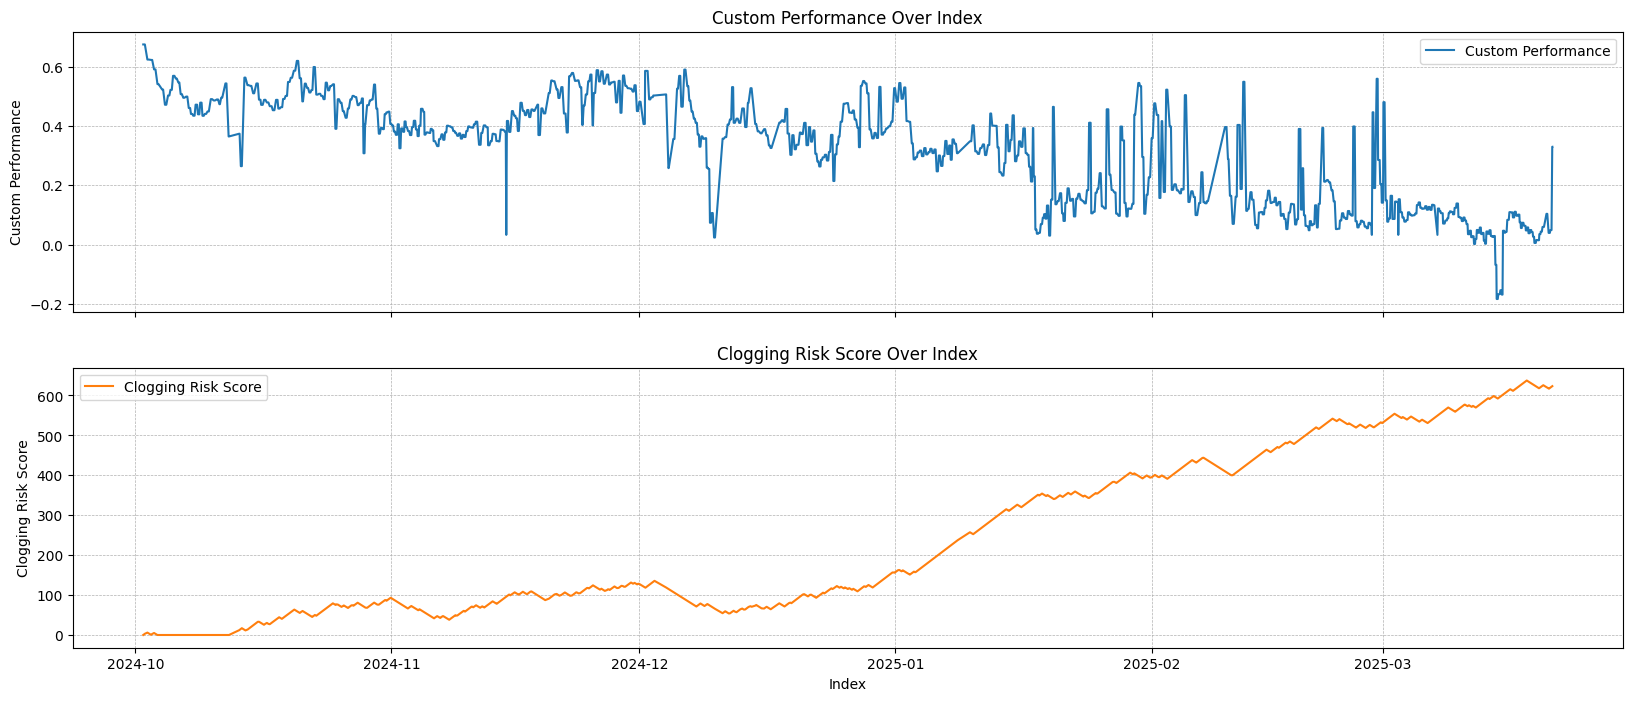

In [ ]:
import matplotlib.pyplot as plt
df_copy = DF_lv1_stats.copy()

fig, axs = plt.subplots(3, 1, figsize=(20, 8), sharex=True)

# Plot Custom Performance
axs[0].plot(df_copy.index, df_copy['Custom_Performance'], label='Custom Performance', color='tab:blue')
axs[0].set_ylabel("Custom Performance")
axs[0].set_title("Custom Performance Over Index")
axs[0].grid(True, linestyle='--', linewidth=0.5)
axs[0].legend()

# Plot Clogging Risk Score
axs[1].plot(df_copy.index, df_copy['Clogging_Risk_Score'], label='Clogging Risk Score', color='tab:orange')
axs[1].set_xlabel("Index")
axs[1].set_ylabel("Clogging Risk Score")
axs[1].set_title("Clogging Risk Score Over Index")
axs[1].grid(True, linestyle='--', linewidth=0.5)
axs[1].legend()
# Plot Clogging Risk Score
axs[2].plot(df_copy.index, df_copy['Maximum_Operating_Pressure'], label='Máxima presión operativa', color='tab:red')
axs[2].set_xlabel("Index")
axs[2].set_ylabel("Máxima presión operativa")
axs[2].set_title("Máxima presión operativa")
axs[2].grid(True, linestyle='--', linewidth=0.5)
axs[2].legend()
plt.tight_layout()
plt.show()


🧠 Train R²: 0.8954
🧪 Test  R²: 0.8492
📉 Gap     : 0.0462


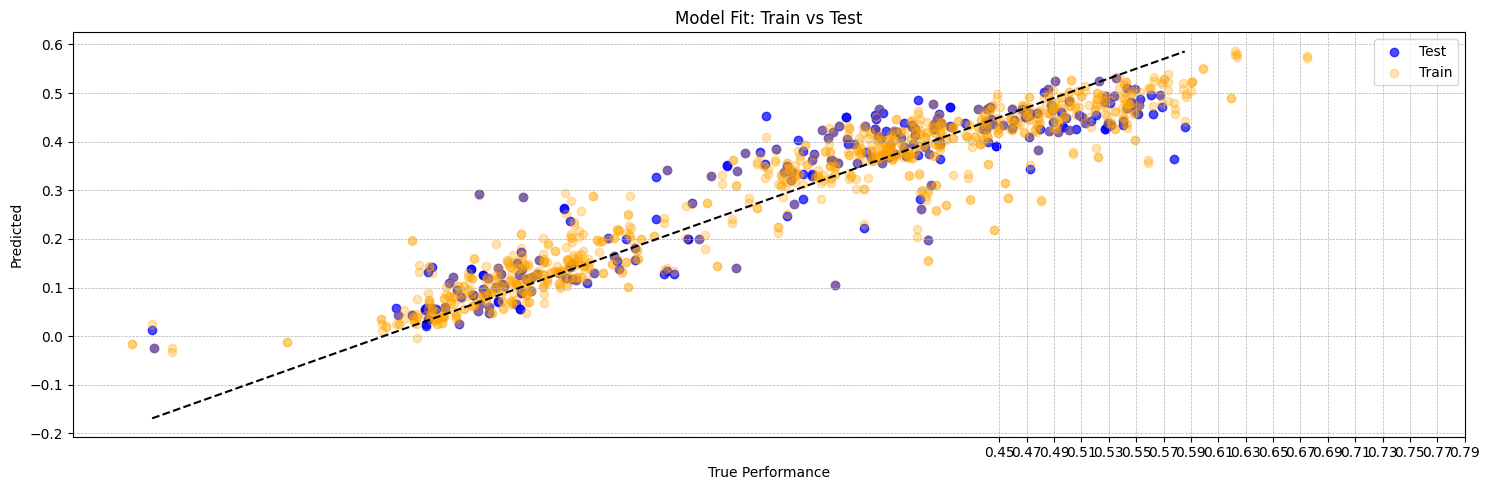

In [46]:
from sklearn.metrics import r2_score

# Predict on both sets
train_preds = final_model.predict(X_train)
test_preds = final_model.predict(X_test)

# R² scores
r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)

print(f"🧠 Train R²: {r2_train:.4f}")
print(f"🧪 Test  R²: {r2_test:.4f}")
print(f"📉 Gap     : {r2_train - r2_test:.4f}")

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
plt.scatter(y_test, test_preds, alpha=0.7, label="Test", color="blue")
plt.scatter(y_train, train_preds, alpha=0.3, label="Train", color="orange")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k')

# Add more x-axis ticks
x_ticks = np.arange(0.45, 0.80, 0.02)  # adjust as needed
plt.xticks(x_ticks)

plt.xlabel("True Performance")
plt.ylabel("Predicted")
plt.title("Model Fit: Train vs Test")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Guardar mejor modelo

In [ ]:
import joblib

# Save to file
joblib.dump(best_model, "best_xgb_model.pkl")

# To load it later:
# best_model = joblib.load("best_xgb_model.pkl")


NameError: name 'best_model' is not defined

### Análisis de shap sobre el mejor modelo

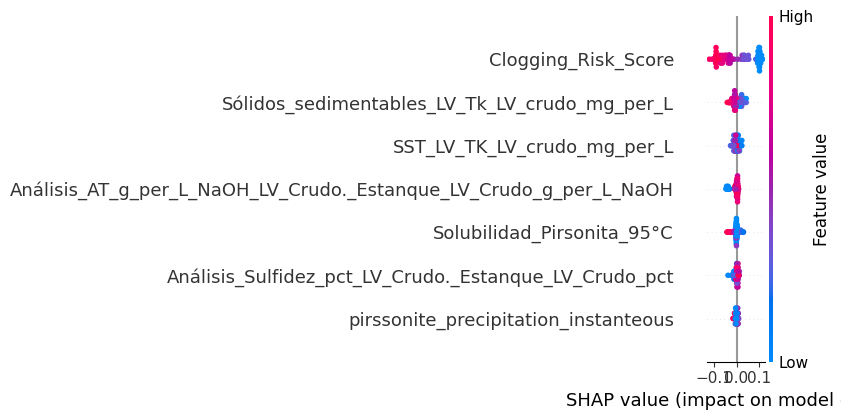

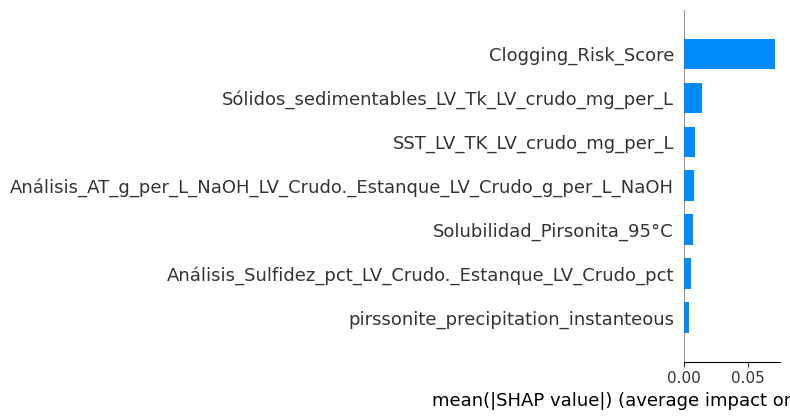

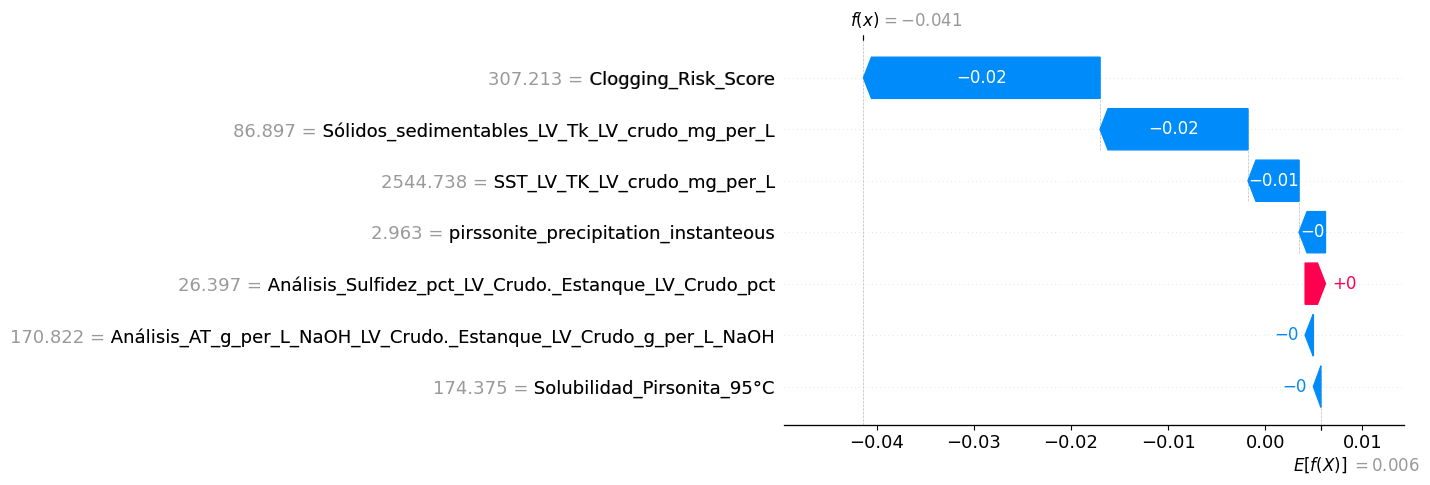

In [ ]:
import shap
import matplotlib.pyplot as plt

# Re-load model (if starting from saved state)
# final_model = joblib.load("best_xgb_model_714.pkl")

# Create SHAP explainer
explainer = shap.Explainer(final_model, X_train)

# Calculate SHAP values
shap_values = explainer(X_test)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X_test, show=True)

# Optional: Bar chart summary (simplified)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

# Optional: Single prediction explanation
shap.plots.waterfall(shap_values[0])


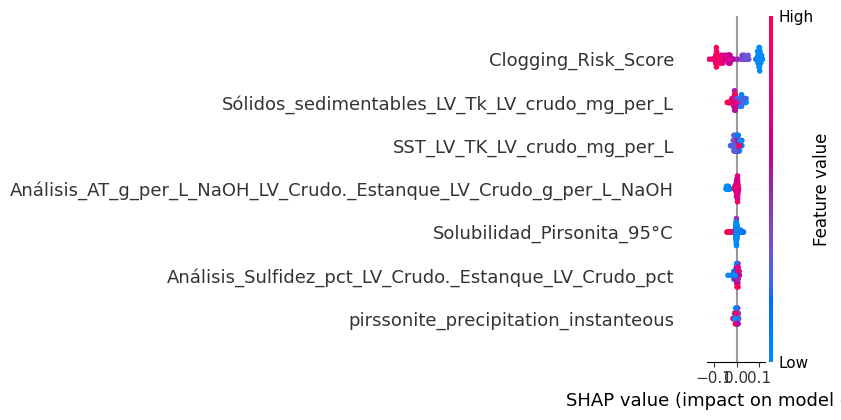

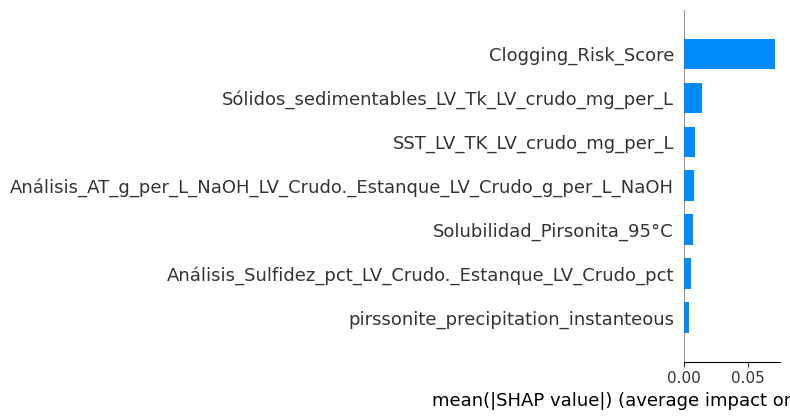

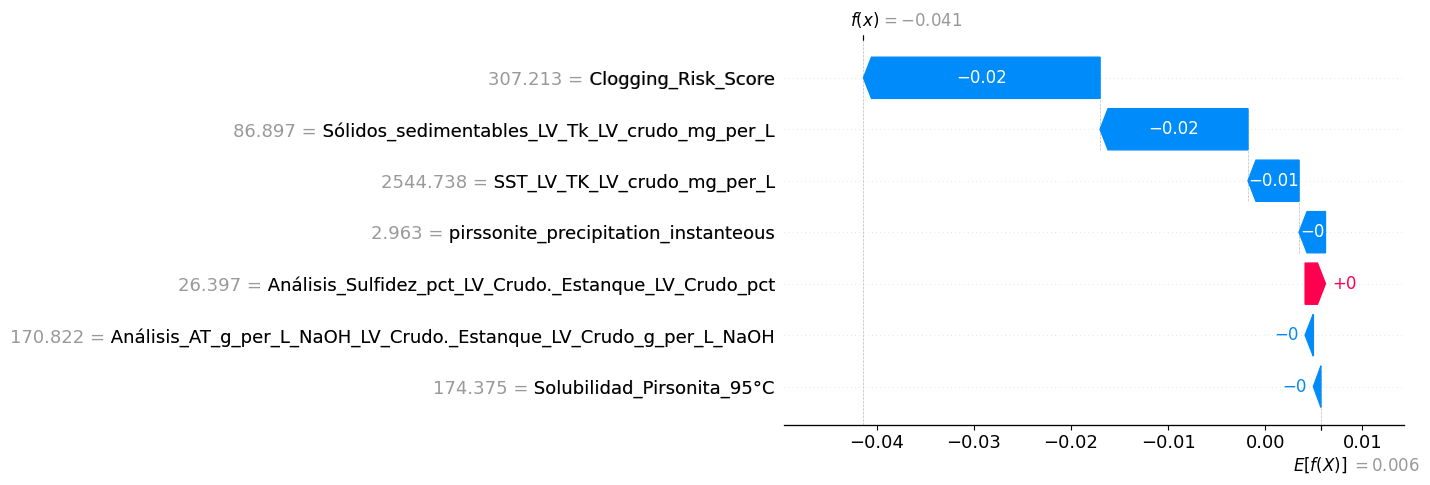

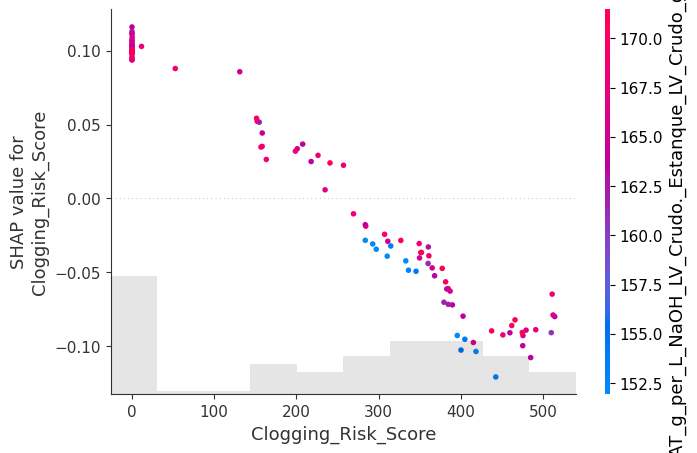

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# --- Crear el SHAP explainer (válido para modelos tipo árbol)
explainer = shap.Explainer(final_model, X_train)

# --- Calcular los valores SHAP para el set de test
shap_values = explainer(X_test)

# --- 1. SHAP Summary Plot (tipo swarm)
shap.summary_plot(shap_values, X_test)

# --- 2. SHAP Summary Plot (barras: importancia media absoluta)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# --- 3. Waterfall plot para una predicción específica
shap.plots.waterfall(shap_values[0])

# --- 4. Dependence plot de la variable más importante
top_feature = X_test.columns[np.argsort(np.abs(shap_values.values).mean(0))[-1]]
shap.plots.scatter(shap_values[:, top_feature], color=shap_values)


                                             Feature  Mean_Abs_SHAP
6                                Clogging_Risk_Score       0.071116
2      Sólidos_sedimentables_LV_Tk_LV_crudo_mg_per_L       0.014420
3                        SST_LV_TK_LV_crudo_mg_per_L       0.008818
0  Análisis_AT_g_per_L_NaOH_LV_Crudo._Estanque_LV...       0.007893
4                         Solubilidad_Pirsonita_95°C       0.007287
1  Análisis_Sulfidez_pct_LV_Crudo._Estanque_LV_Cr...       0.005976
5               pirssonite_precipitation_instanteous       0.004408
                                             Feature  Mean_Abs_SHAP
6                                Clogging_Risk_Score       0.071116
2      Sólidos_sedimentables_LV_Tk_LV_crudo_mg_per_L       0.014420
3                        SST_LV_TK_LV_crudo_mg_per_L       0.008818
0  Análisis_AT_g_per_L_NaOH_LV_Crudo._Estanque_LV...       0.007893
4                         Solubilidad_Pirsonita_95°C       0.007287
1  Análisis_Sulfidez_pct_LV_Crudo._Estanque_LV_C

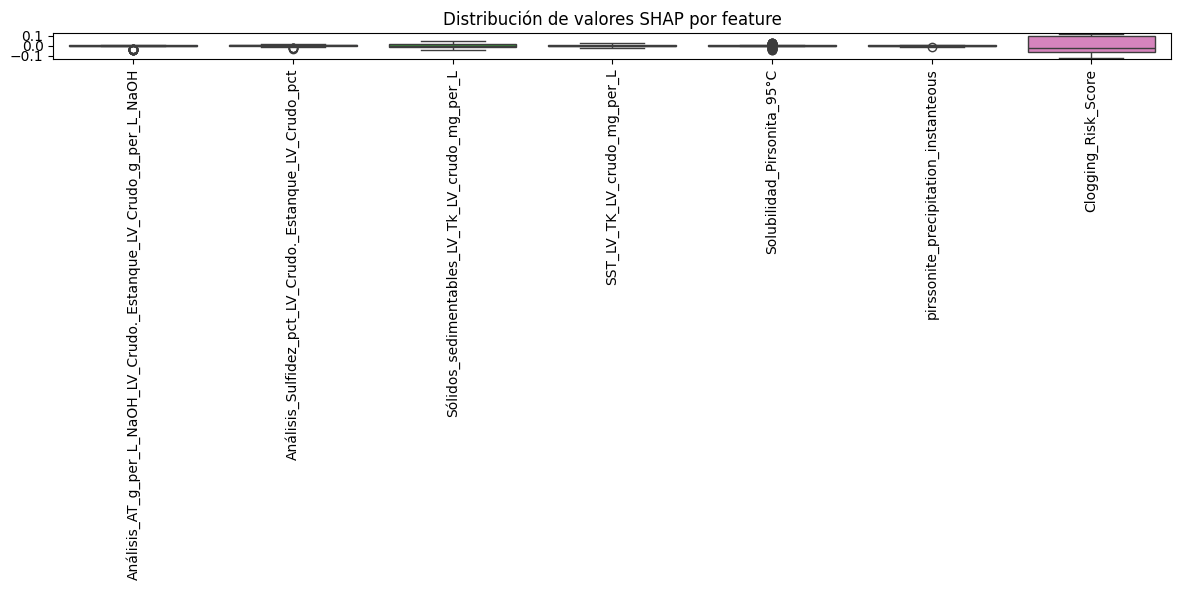

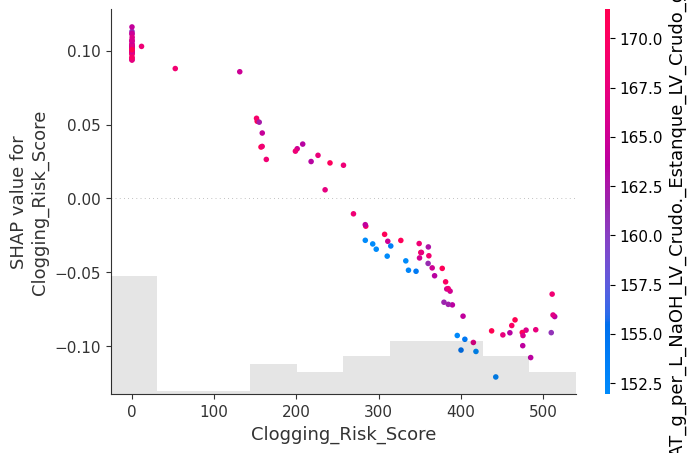

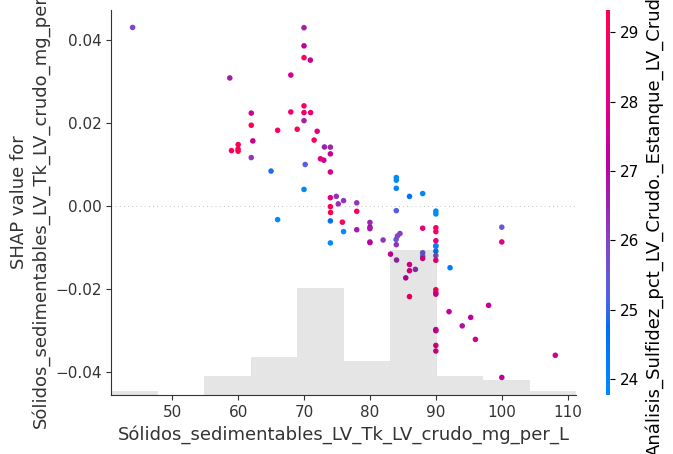

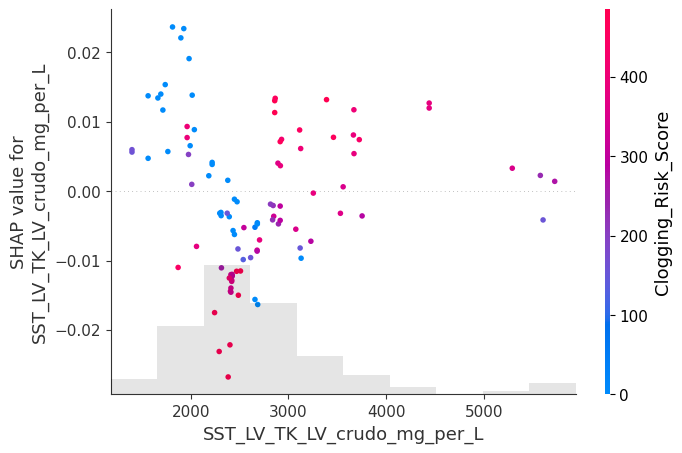

<Figure size 640x480 with 0 Axes>

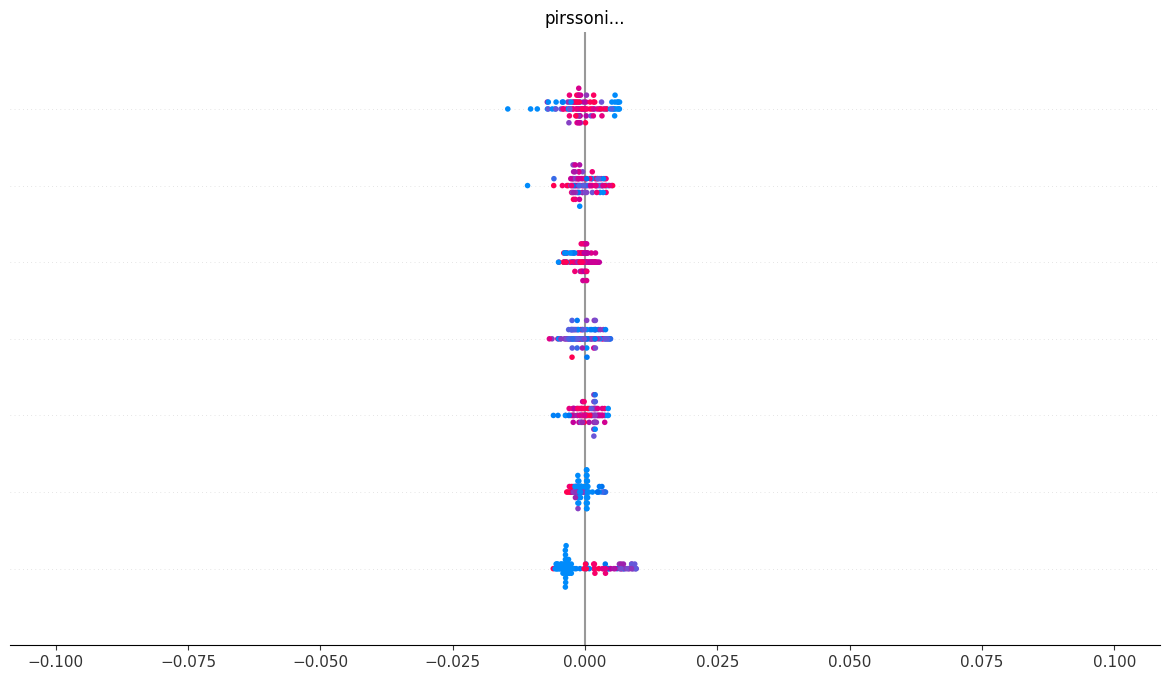

Clogging_Risk_Score                                      0.024346
Sólidos_sedimentables_LV_Tk_LV_crudo_mg_per_L            0.015224
SST_LV_TK_LV_crudo_mg_per_L                              0.005254
pirssonite_precipitation_instanteous                     0.002719
Análisis_Sulfidez_pct_LV_Crudo._Estanque_LV_Crudo_pct    0.002096
dtype: float64


In [ ]:
import pandas as pd
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_Abs_SHAP": mean_abs_shap
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

print(feature_importance.head(10))
import pandas as pd
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame({
    "Feature": X_test.columns,
    "Mean_Abs_SHAP": mean_abs_shap
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

print(feature_importance.head(10))
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(shap_values.values, columns=X_test.columns))
plt.xticks(rotation=90)
plt.title("Distribución de valores SHAP por feature")
plt.tight_layout()
plt.show()
top_features = feature_importance['Feature'].head(3).values

for feat in top_features:
    shap.plots.scatter(shap_values[:, feat], color=shap_values, show=True)
interaction_values = shap.TreeExplainer(final_model).shap_interaction_values(X_test)

# SHAP interaction summary
shap.summary_plot(interaction_values, X_test, max_display=10)
# Obtener las 5 variables más influyentes para una predicción específica
instance = 0
individual_shap = pd.Series(shap_values[instance].values, index=X_test.columns)
print(individual_shap.abs().sort_values(ascending=False).head(5))



## XGBoost pirssonita

In [ ]:
df_lv1

,Análisis Na2CO3 (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis AT (g/L NaOH) LV Crudo. Estanque LV Crudo [g/L NaOH],Análisis Sulfidez (%) LV Crudo. Estanque LV Crudo [%],Sólidos sedimentables LV Tk LV crudo [mg/L],Flujo alimentacion licor verde crudo filtro licor verde 2 [m³/h],Flujo alimentacion licor verde crudo filtro licor verde 1 [m³/h],Presion linea DNCG filtro licor verde 1 (SRS) [bar],Eficiencia filtro licor verde 2 [m³/h],Eficiencia filtro licor verde 1 [m³/h],Presion tope filtro de licor verde 1 [barg],Presion tope filtro de licor verde 2 [barg],Nivel estanque de licor verde crudo - Medidor tipo radar [%],Nivel estanque de licor verde crudo - Medidor tipo presión [%],Secuencia de filtrado filtro LV1 [],Secuencia de lavado tela Filtro LV1 [],Secuencia de filtrado filtro LV2 [],Secuencia de lavado tela Filtro LV2 [],Solubilidad Pirsonita 95°C,ATT límite Teórico 2da ecc
timestamp,,,,,,,,,,,,,,,,,,,
2024-12-01 23:00:00-03:00,116.239998,166.559998,27.860001,100.0,631.795654,379.212708,2.617960,315.170135,196.723389,2.652237,2.171883,50,46,-1.0,0.0,0.0,-1.0,174.800611,165.87401
2024-12-01 23:05:00-03:00,116.239998,166.559998,27.860001,100.0,634.450867,322.984375,2.598890,315.170135,196.723389,2.638197,2.177497,50,45,-1.0,0.0,0.0,-1.0,174.800611,165.87401
2024-12-01 23:10:00-03:00,116.239998,166.559998,27.860001,100.0,900.000000,422.461304,2.545301,315.170135,196.723389,2.580848,2.116655,51,45,-1.0,0.0,0.0,-1.0,174.800611,165.87401
2024-12-01 23:15:00-03:00,116.239998,166.559998,27.860001,100.0,900.000000,420.803528,2.580299,315.170135,196.723389,2.619703,2.193759,51,45,-1.0,0.0,0.0,-1.0,174.800611,165.87401
2024-12-01 23:20:00-03:00,116.239998,166.559998,27.860001,100.0,900.000000,519.207092,2.625799,315.170135,196.723389,2.666747,2.229092,51,45,-1.0,0.0,0.0,-1.0,174.800611,165.87401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-07 23:40:00-03:00,110.239998,154.800003,26.360001,72.0,900.000000,631.689270,2.903877,367.020752,541.351807,2.954415,2.184750,42,34,-1.0,0.0,0.0,-1.0,176.884881,166.77113
2025-04-07 23:45:00-03:00,110.239998,154.800003,26.360001,72.0,900.000000,692.637024,2.865018,367.020752,541.351807,2.918363,2.192581,42,34,-1.0,0.0,0.0,-1.0,176.884881,166.77113
2025-04-07 23:50:00-03:00,110.239998,154.800003,26.360001,72.0,900.000000,655.246216,2.877565,367.020752,541.351807,2.925884,2.189773,42,34,-1.0,0.0,0.0,-1.0,176.884881,166.77113


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def train_xgboost_model(summary_df):
    # Features e identificadores
    feature_cols = ['Mean_Flow', 'Min_Flow', 'Max_Flow', 'Std_Flow', 'Flow_AUC']
    target_col = 'Duration_min'

    X = summary_df[feature_cols]
    y = summary_df[target_col]/summary_df['Duration_min']

    # División train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Escalado (opcional, pero a veces mejora para XGBoost)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Param grid
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [2, 3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5]
    }

    model = XGBRegressor(objective='reg:squarederror', random_state=42)

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=30,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Entrenamiento
    search.fit(X_train_scaled, y_train)

    # Predicciones
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)

    # Evaluación
    print("\n📊 Evaluación del modelo:")
    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"MAE:  {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"R²:   {r2_score(y_test, y_pred):.2f}")

    print("\n🔧 Mejor configuración encontrada:")
    print(search.best_params_)

    return best_model, search.best_params_, scaler
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5]
}
